In this example we learn about the different in data/drift distributions that results from 2 datasets. Here we use the model explainiabilty aspect of ML, available in CinnaMon library and its ModelDriftExplainer functionality, to explain drift resulting from a classifier model. Here OutputDriftDetector function helps us to identify drift from XGBoost's classifier model.

The experiment is done with a random split so we should not detect a data drift. We had run our experiments on California Housing Dataset.

# Output Drift detector on XGBoost Classifier ML Model

In [1]:
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

from cinnamon.drift import OutputDriftDetector

RANDOM_SEED = 2021

/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# California Housing Data

In [2]:
from sklearn.datasets import fetch_california_housing

from sklearn.datasets import fetch_openml
california = fetch_openml(name="house_prices", as_frame=True)

california_df = pd.DataFrame(california.data, columns=california.feature_names)
california_df.head(5)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,12,2008,WD,Normal


In [3]:
california_df.shape

(1460, 80)

In [4]:
# checking features
california_cat = california_df.select_dtypes(include='O').keys()
# display variabels
california_cat,california_df.columns

(Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
        'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
        'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
        'SaleType', 'SaleCondition'],
       dtype='object'),
 Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
        'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
        'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
        'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
        'RoofStyle',

In [5]:
# creating new df
# setting columns we use
new_df = california_df[california_cat]
new_df.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
3,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
4,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal


In [6]:
# unique values in each columns
for x in new_df.columns:
    #prinfting unique values
    print(x ,':', len(new_df[x].unique()))

MSZoning : 5
Street : 2
Alley : 3
LotShape : 4
LandContour : 4
Utilities : 2
LotConfig : 5
LandSlope : 3
Neighborhood : 25
Condition1 : 9
Condition2 : 8
BldgType : 5
HouseStyle : 8
RoofStyle : 6
RoofMatl : 8
Exterior1st : 15
Exterior2nd : 16
MasVnrType : 5
ExterQual : 4
ExterCond : 5
Foundation : 6
BsmtQual : 5
BsmtCond : 5
BsmtExposure : 5
BsmtFinType1 : 7
BsmtFinType2 : 7
Heating : 6
HeatingQC : 5
CentralAir : 2
Electrical : 6
KitchenQual : 4
Functional : 7
FireplaceQu : 6
GarageType : 7
GarageFinish : 4
GarageQual : 6
GarageCond : 6
PavedDrive : 3
PoolQC : 4
Fence : 5
MiscFeature : 5
SaleType : 9
SaleCondition : 6


In [7]:
# for all categorical variables we selected
import numpy as np
def top_x(df2,feature_list):
    
    for featr in feature_list:
        #df2[featr].value_counts().sort_values(ascending=False).head(20)
        top_x_labels = [x for x in df2[featr].value_counts().sort_values(ascending=False).head(20).index]
        for label in top_x_labels:
            df2[featr+'_'+label] = np.where(df2[featr]==label,1,0)
            # read the data again
            #data = california_df[california_cat]
    return df2
        

#encode Nighborhood into the 10 most frequent categories
data = top_x(california_df,list(california_cat))
california_n_cat = data.select_dtypes(include='O').keys()
print(len(data.columns), len(california_df.columns), len(california_n_cat))


data = data.drop(columns = list(california_cat))
# display data
data.head()


327 327 43


<ipython-input-7-59bd48f9c89f>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[featr+'_'+label] = np.where(df2[featr]==label,1,0)
<ipython-input-7-59bd48f9c89f>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[featr+'_'+label] = np.where(df2[featr]==label,1,0)
<ipython-input-7-59bd48f9c89f>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_CWD,SaleType_Oth,SaleType_Con,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_Abnorml,SaleCondition_Family,SaleCondition_Alloca,SaleCondition_AdjLand
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,0,1,0,0,0,0,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,0,1,0,0,0,0,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,0,1,0,0,0,0,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,0,0,0,1,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,0,1,0,0,0,0,0


In [8]:
print(len(data.columns), data.columns)
california.target

284 Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       ...
       'SaleType_ConLw', 'SaleType_CWD', 'SaleType_Oth', 'SaleType_Con',
       'SaleCondition_Normal', 'SaleCondition_Partial',
       'SaleCondition_Abnorml', 'SaleCondition_Family', 'SaleCondition_Alloca',
       'SaleCondition_AdjLand'],
      dtype='object', length=284)


0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [9]:
df_target = pd.DataFrame(california.target)
df_target.head(5)

,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000


### Here we try to group the sales volume to 10 groups , as we have a classification problem and trying to predict the sales group

In [11]:
df_target['sales_group'] = pd.cut(df_target['SalePrice'], bins=10)
df_target.head(5)

,SalePrice,sales_group
0,208500,"(178920.0, 250930.0]"
1,181500,"(178920.0, 250930.0]"
2,223500,"(178920.0, 250930.0]"
3,140000,"(106910.0, 178920.0]"
4,250000,"(178920.0, 250930.0]"


In [12]:
uniq_sales_grp = df_target['sales_group'].unique()
uniq_sales_grp, len(uniq_sales_grp)

([(178920.0, 250930.0], (106910.0, 178920.0], (250930.0, 322940.0], (322940.0, 394950.0], (34179.9, 106910.0], (394950.0, 466960.0], (466960.0, 538970.0], (538970.0, 610980.0], (682990.0, 755000.0], (610980.0, 682990.0]]
 Categories (10, interval[float64, right]): [(34179.9, 106910.0] < (106910.0, 178920.0] < (178920.0, 250930.0] < (250930.0, 322940.0] ... (466960.0, 538970.0] < (538970.0, 610980.0] < (610980.0, 682990.0] < (682990.0, 755000.0]],
 10)

In [13]:
df_target['sales_group'].replace(to_replace=uniq_sales_grp, value=[0, 1, 2, 3, 4, 5, 6, 7, 8 , 9], inplace=True)
df_target['sales_group'] = df_target['sales_group'].astype(int)
df_target.head(5)

,SalePrice,sales_group
0,208500,0
1,181500,0
2,223500,0
3,140000,1
4,250000,0


# Build XGBoost model

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data, df_target['sales_group'], test_size=0.4, random_state=RANDOM_SEED)

In [15]:
np.unique(y_train), np.unique(y_test)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [16]:
clf = XGBClassifier(n_estimators=1000,
                    booster="gbtree",
                    learning_rate=0.05,
                    max_depth=6,
                    use_label_encoder=False,
                    seed=2021)

In [17]:
clf.fit(X=X_train, y=y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=20, verbose=10)

[23:16:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:2.17432


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[10]	validation_0-mlogloss:1.48125
[20]	validation_0-mlogloss:1.14661
[30]	validation_0-mlogloss:0.94107
[40]	validation_0-mlogloss:0.81484
[50]	validation_0-mlogloss:0.73566
[60]	validation_0-mlogloss:0.68405
[70]	validation_0-mlogloss:0.65094
[80]	validation_0-mlogloss:0.62726
[90]	validation_0-mlogloss:0.61370
[100]	validation_0-mlogloss:0.60440
[110]	validation_0-mlogloss:0.60018
[120]	validation_0-mlogloss:0.59726
[130]	validation_0-mlogloss:0.59583
[140]	validation_0-mlogloss:0.59645
[150]	validation_0-mlogloss:0.59650
[155]	validation_0-mlogloss:0.59717


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=2021, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=2021, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

# Analyze data drift with ModelDriftExplainer

The experiment is done with a random split so we should not detect a data drift

### prediction_type == "proba"

In [18]:
output_drift_detector = OutputDriftDetector(task='classification', prediction_type='proba')

In [19]:
output_drift_detector.fit(clf.predict_proba(X_train), clf.predict_proba(X_test), y1=y_train, y2=y_test)

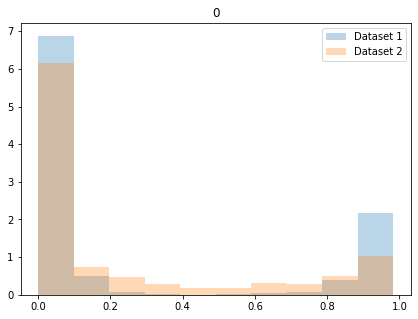

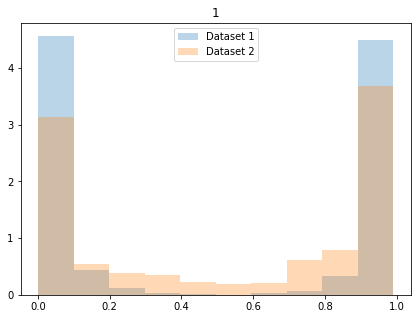

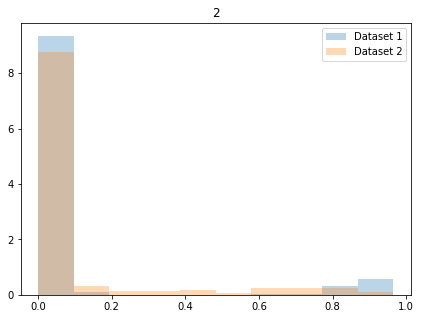

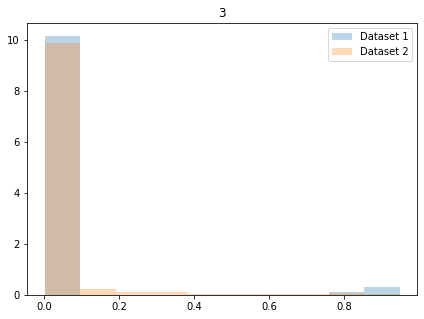

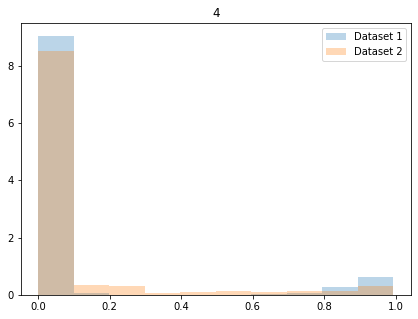

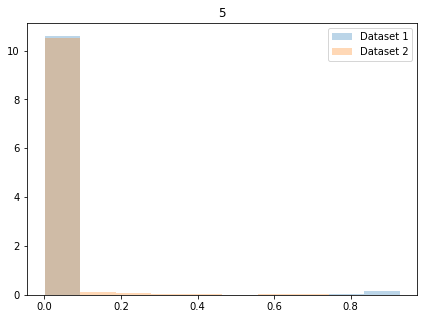

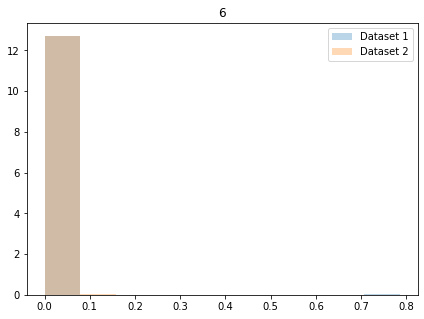

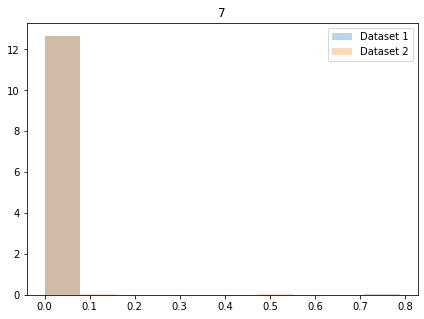

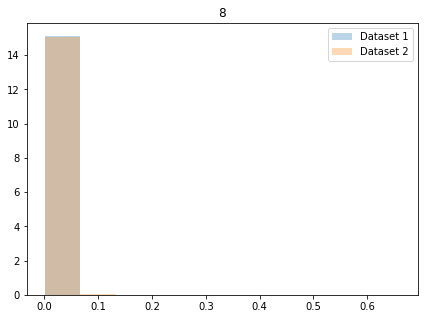

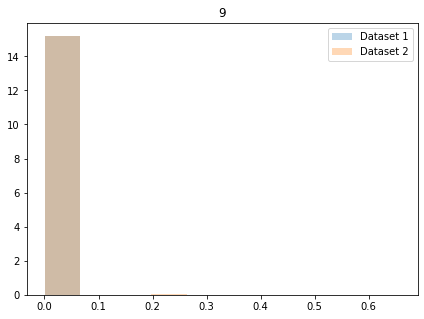

[DriftMetricsNum(mean_difference=-0.024537734833578434, wasserstein=0.05775523385436744, ks_test=BaseStatisticalTestResult(statistic=0.12157534246575342, pvalue=5.882660856555159e-05)),
 DriftMetricsNum(mean_difference=0.04619456663276983, wasserstein=0.07493298196926985, ks_test=BaseStatisticalTestResult(statistic=0.15639269406392695, pvalue=6.297852304043064e-08)),
 DriftMetricsNum(mean_difference=0.0001358837307883637, wasserstein=0.028937219798784986, ks_test=BaseStatisticalTestResult(statistic=0.12614155251141554, pvalue=2.6473933937820454e-05)),
 DriftMetricsNum(mean_difference=-0.008010920220857098, wasserstein=0.020989977079848964, ks_test=BaseStatisticalTestResult(statistic=0.1780821917808219, pvalue=3.690000366637743e-10)),
 DriftMetricsNum(mean_difference=-0.0076545115789402735, wasserstein=0.03173780711670727, ks_test=BaseStatisticalTestResult(statistic=0.22031963470319635, pvalue=2.3403279955113446e-15)),
 DriftMetricsNum(mean_difference=-0.0075804896685722715, wasserstein

In [20]:
# no apparent drift in distributions of log-softmax predictions
output_drift_detector.plot_prediction_drift()
output_drift_detector.get_prediction_drift()

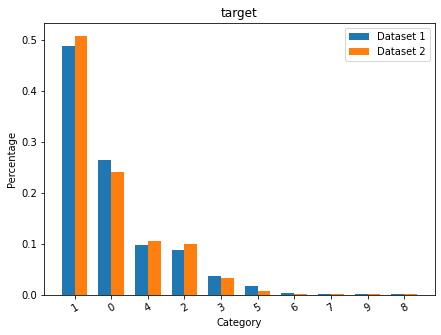

DriftMetricsCat(wasserstein=0.03995433789954338, jensen_shannon=0.04512116433219914, chi2_test=Chi2TestResult(statistic=5.331605404245089, pvalue=0.8044965632012276, dof=9, contingency_table=        0      1     2     3     4     5    6    7    8    9
X1  232.0  427.0  77.0  32.0  86.0  15.0  3.0  2.0  1.0  1.0
X2  141.0  296.0  58.0  19.0  62.0   4.0  1.0  1.0  1.0  1.0))

In [21]:
output_drift_detector.plot_target_drift()
output_drift_detector.get_target_drift()

In [22]:
output_drift_detector.get_performance_metrics_drift()

PerformanceMetricsDrift(dataset1=ClassificationMetrics(accuracy=1.0, log_loss=0.08016032902591169), dataset2=ClassificationMetrics(accuracy=0.7688356164383562, log_loss=0.5957360187256303))

In [23]:
output_drift_detector.class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

### prediction_type == "raw"

In [24]:
output_drift_detector3 = OutputDriftDetector(task='classification', prediction_type='raw')

In [25]:
output_drift_detector3.fit(clf.predict(X_train, output_margin=True), clf.predict(X_test, output_margin=True),
                           y1=y_train, y2=y_test)

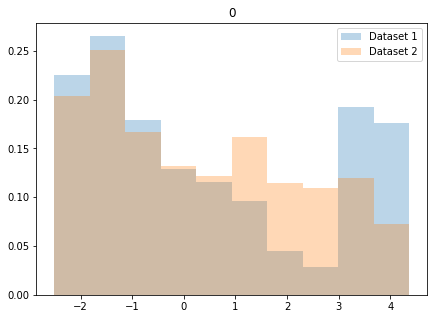

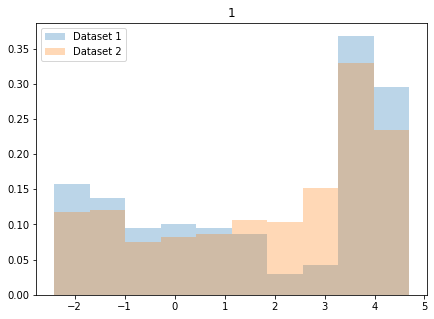

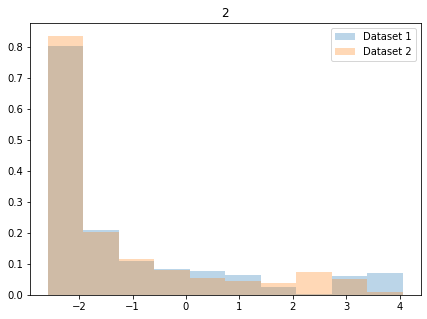

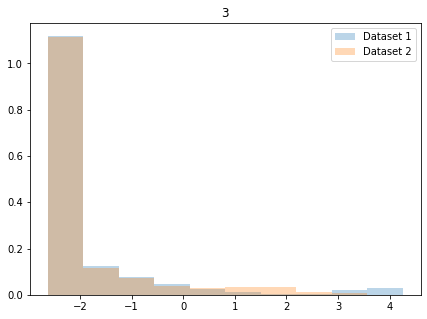

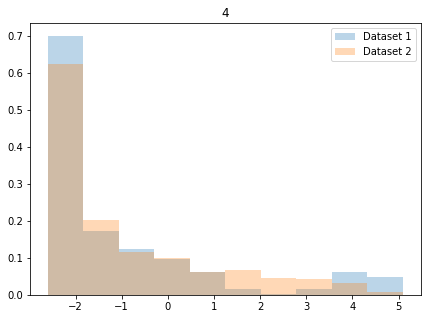

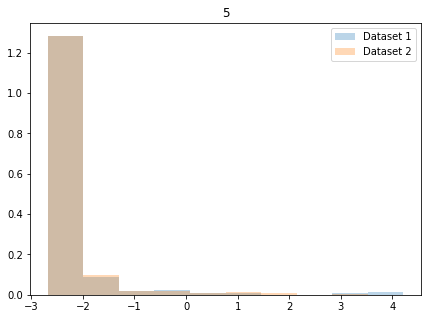

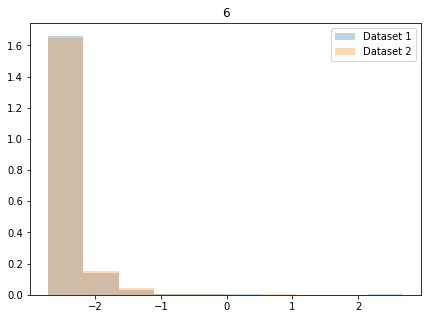

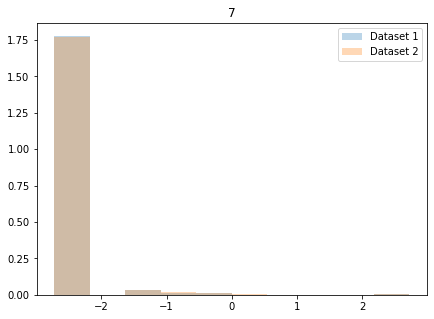

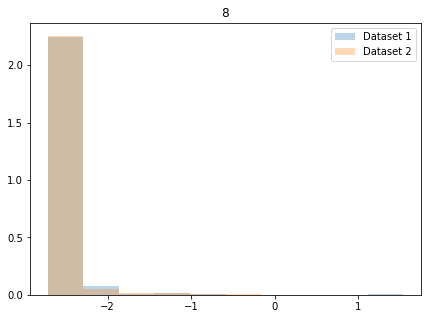

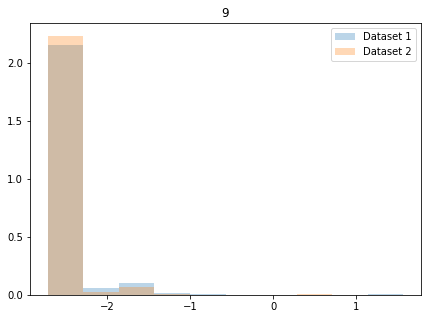

[DriftMetricsNum(mean_difference=-0.10034750223071548, wasserstein=0.27613457148021825, ks_test=BaseStatisticalTestResult(statistic=0.13527397260273974, pvalue=4.904773614294285e-06)),
 DriftMetricsNum(mean_difference=0.1531966243696199, wasserstein=0.3425022809464297, ks_test=BaseStatisticalTestResult(statistic=0.11929223744292237, pvalue=8.672055184111803e-05)),
 DriftMetricsNum(mean_difference=-0.10614862738041109, wasserstein=0.13136618076844916, ks_test=BaseStatisticalTestResult(statistic=0.0593607305936073, pvalue=0.1645678556422801)),
 DriftMetricsNum(mean_difference=-0.01097885799566578, wasserstein=0.09706013001975733, ks_test=BaseStatisticalTestResult(statistic=0.0319634703196347, pvalue=0.8585132242839074)),
 DriftMetricsNum(mean_difference=0.09325754457364943, wasserstein=0.27875638312897244, ks_test=BaseStatisticalTestResult(statistic=0.0639269406392694, pvalue=0.11069875516835764)),
 DriftMetricsNum(mean_difference=-0.04936948242133754, wasserstein=0.05233545872259497, ks

In [26]:
# no apparent drift in distributions of log-softmax predictions
output_drift_detector3.plot_prediction_drift()
output_drift_detector3.get_prediction_drift()

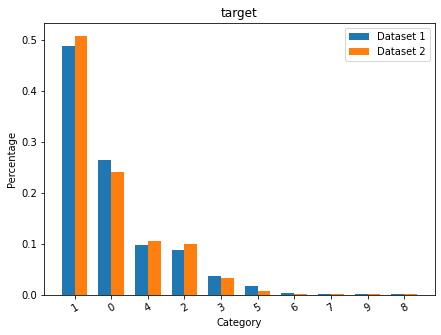

DriftMetricsCat(wasserstein=0.03995433789954338, jensen_shannon=0.04512116433219914, chi2_test=Chi2TestResult(statistic=5.331605404245089, pvalue=0.8044965632012276, dof=9, contingency_table=        0      1     2     3     4     5    6    7    8    9
X1  232.0  427.0  77.0  32.0  86.0  15.0  3.0  2.0  1.0  1.0
X2  141.0  296.0  58.0  19.0  62.0   4.0  1.0  1.0  1.0  1.0))

In [27]:
output_drift_detector3.plot_target_drift()
output_drift_detector3.get_target_drift()

In [29]:
output_drift_detector3.get_performance_metrics_drift()

PerformanceMetricsDrift(dataset1=ClassificationMetrics(accuracy=1.0, log_loss=0.08016032989710511), dataset2=ClassificationMetrics(accuracy=0.7688356164383562, log_loss=0.5957360204249839))